## Combining unity VR data with imaging data
Temporal alignment using recrded microscope frame trigger signal in unity log

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from unityvr.preproc import logproc
from unityvr.viz import viz, utils
from unityvr.analysis import alignVRImg, imagingVeloCorr
from os.path import sep

import xarray as xr

#### Load preprocessed VR and imaging data

In [6]:
root = '../../../../data_unityvr/'
subdir = 'panoramaTest/56H10_x_7f/BU/f01/panC1'#'dFB/84C10_x_6fdouble/FB/deprived/f02/trial01'

preprocDir = root+'preproc/'+subdir
saveDir = root+'plot/'+subdir
print(saveDir)
img = 'img'
vr = 'uvr'

utils.makemydir(saveDir)

../../../../data_unityvr/plot/panoramaTest/56H10_x_7f/BU/f01/panC1


In [7]:
uvrDat = logproc.loadUVRData(sep.join([preprocDir, vr]))
uvrDat.printMetadata()

imgDat = pd.read_csv(sep.join([preprocDir, img,'roiDFF.csv'])).drop(columns=['Unnamed: 0'])

with open(sep.join([preprocDir, img,'imgMetadata.json'])) as json_file:
    imgMetadat = json.load(json_file)

Metadata:

expid  :  56H10-x-7f_panC1
experiment  :  projectors on, panorama test, 144 Hz frame rate, 56H10 > GCaMP7f in VK5
genotype  :  56H10-x-7f
sex  :  f
flyid  :  f01
trial  :  trial01
date  :  2021-05-31
time  :  18-15-18
notes  :  BU imaging


length of imaging data (ROI time series) 1000


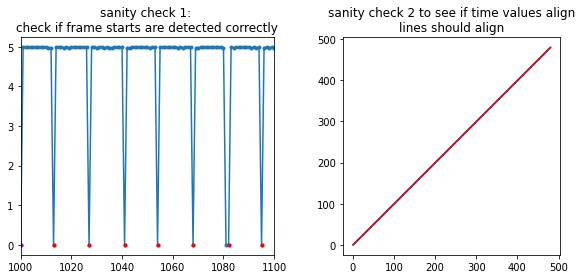

In [8]:
imgInd, volFramePos = alignVRImg.findImgFrameTimes(uvrDat,imgMetadat['fpv'])
print('length of imaging data (ROI time series) {}'.format(len(imgDat)))
fig = alignVRImg.debugAlignmentPlots(uvrDat,imgMetadat, imgInd, volFramePos)

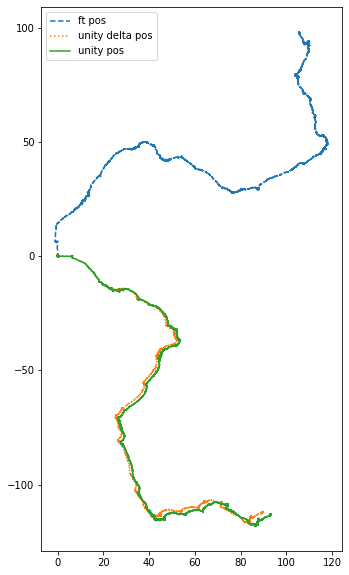

In [9]:
convfmm = 100
convf = 0.047 * convfmm

# add derrived parameter to positional dataframe
uvrDat.posDf['vT'] = np.hypot(np.gradient(uvrDat.posDf.x.values*convfmm), 
                              np.gradient(uvrDat.posDf.y.values*convfmm))*(1/uvrDat.posDf.dt)

testypos = np.cumsum(uvrDat.posDf.dy.values*convfmm*np.cos(np.pi/180*uvrDat.posDf.angle.values) - uvrDat.posDf.dx.values*convfmm*np.sin(np.pi/180*uvrDat.posDf.angle.values))
testxpos = np.cumsum(uvrDat.posDf.dy.values*convfmm*np.sin(np.pi/180*uvrDat.posDf.angle.values) + uvrDat.posDf.dx.values*convfmm*np.cos(np.pi/180*uvrDat.posDf.angle.values))
#vttest= np.hypot(np.gradient(testxpos),np.gradient(testypos) )*(1/uvrDat.posDf.dt)

#uvrDat.posDf['vF'] = np.gradient(uvrDat.posDf.x.values*convfmm)
#uvrDat.posDf['vS'] = np.gradient(uvrDat.posDf.S.values*convfmm)
uvrDat.posDf['vR'] = np.gradient(np.unwrap(uvrDat.posDf.angle.values))

# filter values
from scipy.signal import savgol_filter
order = 3
window = 7

uvrDat.posDf['vT_filt'] = savgol_filter(uvrDat.posDf.vT, window, order)
uvrDat.posDf['vR_filt'] = savgol_filter(uvrDat.posDf.vR, window, order)

if not len(uvrDat.ftDf) == 0:
    fta = -np.cumsum(uvrDat.ftDf['dz'])
    ftf = uvrDat.ftDf['dy'] * convf
    fts = uvrDat.ftDf['dx'] * convf

    ftdx = ftf*np.cos(fta) - fts*np.sin(fta)
    ftdy = ftf*np.sin(fta) + fts*np.cos(fta)

    ftx = np.cumsum(ftdx)
    fty = np.cumsum(ftdy)

    ftvt = np.hypot(ftdx, ftdy)

fig, axs = plt.subplots(1,1,figsize=(10,10))
if not len(uvrDat.ftDf) == 0:
    axs.plot(ftx, fty,'--', label='ft pos')
axs.plot(testxpos, testypos,':', label='unity delta pos')
axs.plot(uvrDat.posDf['x']*convfmm, uvrDat.posDf['y']*convfmm, label='unity pos')
axs.legend()
axs.set_aspect('equal')

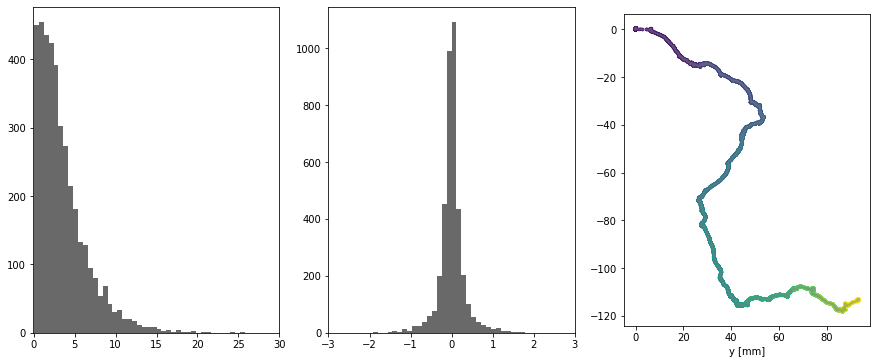

In [10]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
axs[0].hist(uvrDat.posDf.vT[volFramePos], bins=50, range=(0,30),color='dimgrey')
axs[0].set_xlim(-0.1,30)

axs[1].hist(uvrDat.posDf.vR[volFramePos], bins=50, range=(-3,3) ,color='dimgrey')
axs[1].set_xlim(-3,3)

axs[2].plot(uvrDat.posDf['x']*convfmm, uvrDat.posDf['y']*convfmm,color='grey',alpha=0.5)
axs[2].scatter(uvrDat.posDf['x']*convfmm, uvrDat.posDf['y']*convfmm,s=7,c=uvrDat.posDf['time'],cmap='viridis')
axs[2].set_xlabel('x [mm]')
axs[2].set_xlabel('y [mm]')
axs[2].set_aspect('equal')
    
fig.savefig(saveDir+sep+'walking_trace_and_velo.pdf')

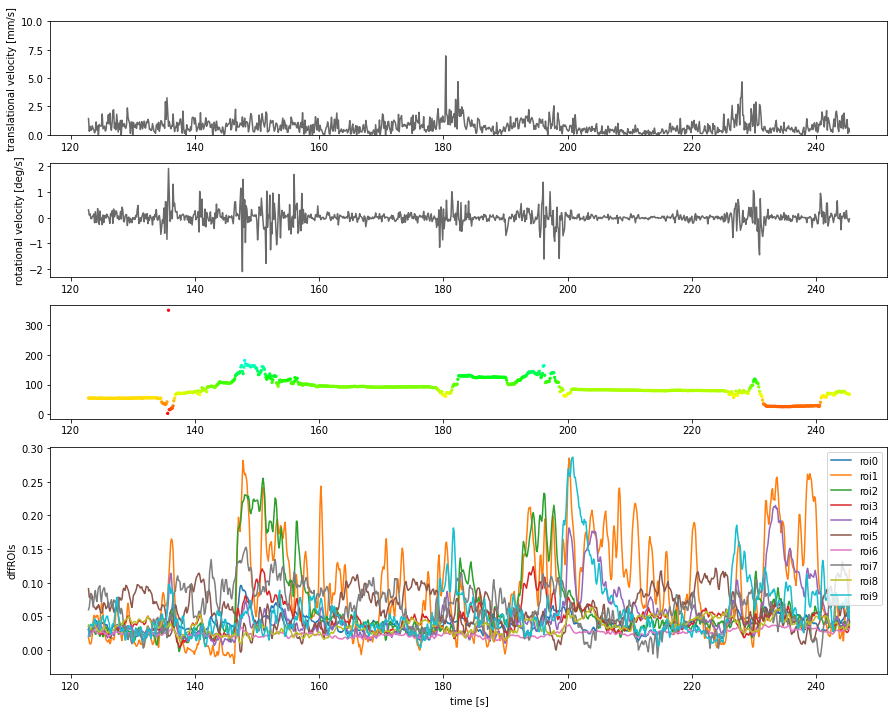

In [40]:
ts = 1000
te = 2000

fig, axs = plt.subplots(4,1,figsize=(15,12), gridspec_kw={'height_ratios':[1,1,1,2]})
axs[0].plot(uvrDat.posDf.time.values[volFramePos][ts:te]
            ,uvrDat.posDf.vT_filt[volFramePos][ts:te]/convf ,color='dimgrey')
axs[0].set_ylim(-0.01,10)
axs[0].set_ylabel('translational velocity [mm/s]')

axs[1].plot(uvrDat.posDf.time.values[volFramePos][ts:te],
            uvrDat.posDf.vR_filt[volFramePos][ts:te] ,color='dimgrey')
axs[1].set_ylabel('rotational velocity [deg/s]')

axs[2].scatter(uvrDat.posDf.time.values[volFramePos][ts:te],
            uvrDat.posDf.angle.values[volFramePos][ts:te],s = 5,
               c=uvrDat.posDf.angle.values[volFramePos][ts:te],cmap='hsv')

for col in imgDat.columns.values[:-1]:
    axs[3].plot(uvrDat.posDf.time.values[volFramePos][ts:te], imgDat[col], label=col)
axs[3].legend(loc=1)
axs[3].set_xlabel('time [s]')
axs[3].set_ylabel('dffROIs')
    
fig.savefig(saveDir+sep+'velo_imaging_overview.pdf')

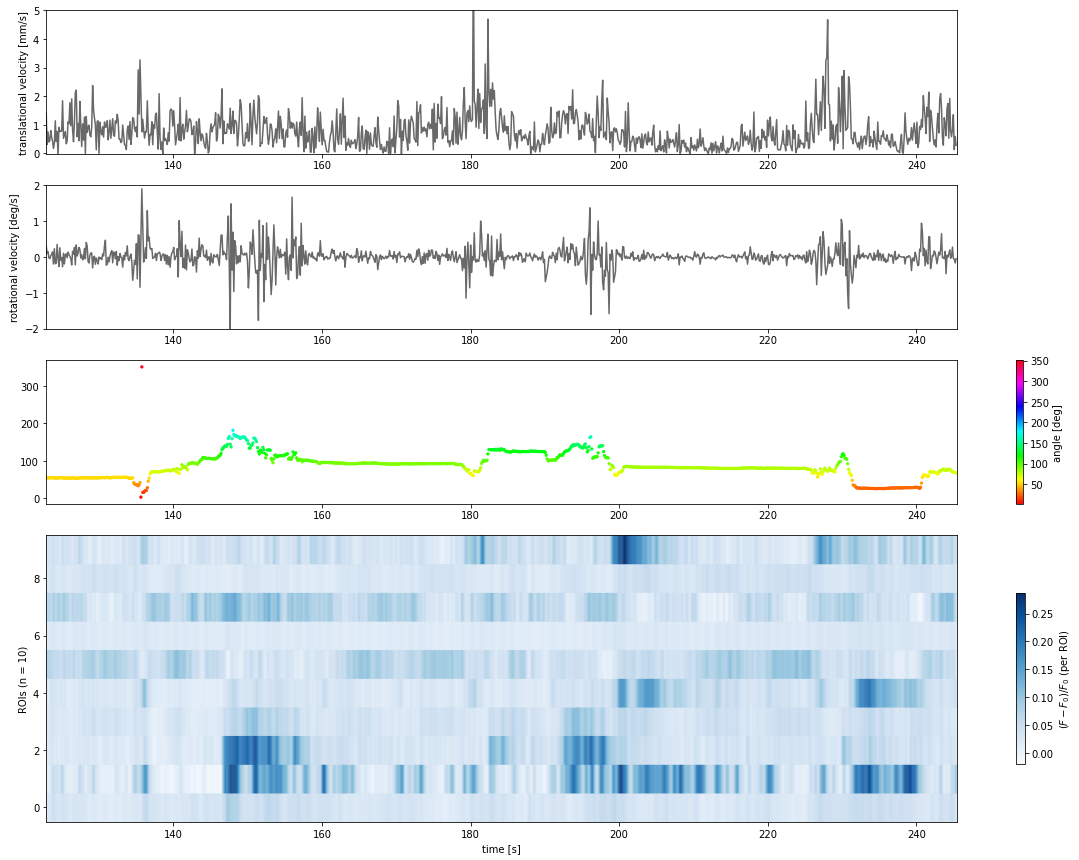

In [50]:
ts = 1000
te = 2000

roiname = 'roi'
if "background" in imgDat.columns:
    nroi = len(imgDat.columns)-2
else:
    nroi = len(imgDat.columns)-1

fig, axs = plt.subplots(4,2,figsize=(15,12), gridspec_kw={'height_ratios':[1,1,1,2],'width_ratios':[8,0.5]})
axs[0,0].plot(uvrDat.posDf.time.values[volFramePos][ts:te]
            ,uvrDat.posDf.vT_filt[volFramePos][ts:te]/convf ,color='dimgrey')
axs[0,0].set_ylim(-0.01,5)
axs[0,0].set_ylabel('translational velocity [mm/s]')


axs[1,0].plot(uvrDat.posDf.time.values[volFramePos][ts:te],
            uvrDat.posDf.vR_filt[volFramePos][ts:te] ,color='dimgrey')
axs[1,0].set_ylim(-2,2)
axs[1,0].set_ylabel('rotational velocity [deg/s]')

cax1 = axs[2,0].scatter(uvrDat.posDf.time.values[volFramePos][ts:te],
            uvrDat.posDf.angle.values[volFramePos][ts:te],s = 5,
               c=uvrDat.posDf.angle.values[volFramePos][ts:te],cmap='hsv')

cax2 = axs[3,0].pcolor(uvrDat.posDf.time.values[volFramePos][ts:te],np.arange(0,nroi),
                 imgDat[["{}{}".format(roiname, i) for i  in range(nroi)]].values.T,
                 cmap='Blues', edgecolors='face', shading='nearest')
axs[3,0].set_xlabel('time [s]')
axs[3,0].set_ylabel('\nROIs (n = {})'.format(nroi))

for ax in axs[:,0]:
    ax.set_xlim(uvrDat.posDf.time.values[volFramePos][ts],
                uvrDat.posDf.time.values[volFramePos][te])
    #myAxisTheme(ax)
for ax in axs[:,1]:
    ax.axis('off')

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax1, ax=axs[2,1])
cbar.set_label('angle [deg]')  # vertically oriented colorbar
cbar = fig.colorbar(cax2, ax=axs[3,1])
cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar
fig.tight_layout()
    
fig.savefig(saveDir+sep+'velo_imaging_overview2.pdf')

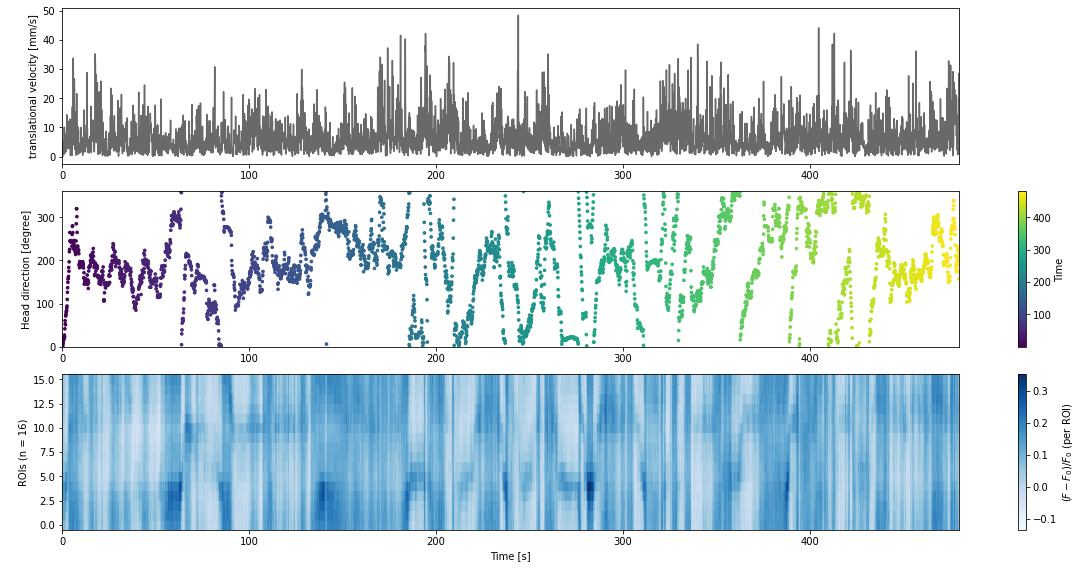

In [80]:
roiname = 'slice'
if "background" in imgDat.columns:
    nroi = len(imgDat.columns)-2
else:
    nroi = len(imgDat.columns)-1
fig, axs = plt.subplots(3,2,figsize=(15,8), gridspec_kw={'width_ratios':[8,0.5]})
axs[0,0].plot(uvrDat.posDf.time.values[volFramePos],uvrDat.posDf.vT.values[volFramePos], color='dimgrey')
axs[0,0].set_ylabel('translational velocity [mm/s]')
#axs[0,0].set_ylim(-3,30)

#axs[1].plot(uvrDat.posDf.time.values[volFramePos],uvrDat.posDf.angle.values[volFramePos])
cax1 = axs[1,0].scatter(uvrDat.posDf.time.values[volFramePos], 
                        uvrDat.posDf.angle.values[volFramePos],s=7,c=uvrDat.posDf.time.values[volFramePos],cmap='viridis')
axs[1,0].set_ylabel('Head direction [degree]')
axs[1,0].set_ylim(0,360)

cax2 = axs[2,0].pcolor(uvrDat.posDf.time.values[volFramePos],np.arange(0,nroi),
                 imgDat[["{}{}".format(roiname, i+1) for i  in range(nroi)]].values.T,
                 cmap='Blues', edgecolors='face', shading='nearest')
axs[2,0].set_xlabel('Time [s]')
axs[2,0].set_ylabel('\nROIs (n = {})'.format(nroi))

for ax in axs[:,0]:
    ax.set_xlim(0,uvrDat.posDf.time.values[volFramePos[-1]])
    #myAxisTheme(ax)
for ax in axs[:,1]:
    ax.axis('off')

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax1, ax=axs[1,1])
cbar.set_label('Time')  # vertically oriented colorbar
cbar = fig.colorbar(cax2, ax=axs[2,1])
cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar
fig.tight_layout()

fig.savefig(saveDir+sep+'headingAndDFF_timeseries.pdf')

In [81]:
from unityvr.analysis import headDirection
roiArcPos = np.linspace(0, 2*np.pi, nroi+1)[:-1]
roidat = imgDat[["{}{}".format(roiname,i+1) for i  in range(nroi)]].values.T

pva = headDirection.computePVA(roiArcPos,roidat)
#pva = headDirection.computePVA(np.arange(nroi),roidat)

startloc = np.mean(roidat[:,50:60],axis=1).argmax(axis=0) - 4 #2
print(roiArcPos[startloc])

#pvaRad = np.arctan2(pva[1,:],pva[0,:])+np.pi #
pvaRad = np.mod(np.arctan2(pva[1,:],pva[0,:]) + np.pi, 2*np.pi)
pvaRadShift = np.mod(np.arctan2(pva[1,:],pva[0,:]) + np.pi + roiArcPos[startloc], 2*np.pi)
pvaLen = np.hypot(pva[0,:],pva[1,:])

5.497787143782138


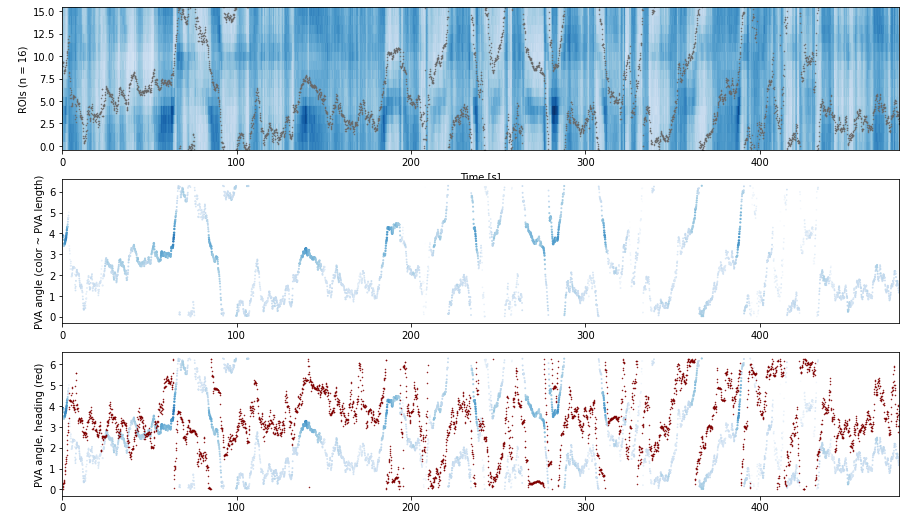

In [82]:
fig, axs = plt.subplots(3,1,figsize=(15, 9))

cax2 = axs[0].pcolor(uvrDat.posDf.time.values[volFramePos],np.arange(0,nroi),
                 imgDat[["{}{}".format(roiname, i+1) for i  in range(nroi)]].values.T,
                 cmap='Blues', edgecolors='face', shading='nearest')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('\nROIs (n = {})'.format(nroi))
axs[0].plot(uvrDat.posDf.time.values[volFramePos], pvaRadShift*nroi/(2*np.pi)-0.5, '.',color='dimgrey', markersize=1)


#axs[1].plot(uvrDat.posDf.time.values[volFramePos], pvaRadShift,'.',color='grey', markersize=1)
axs[1].scatter(uvrDat.posDf.time.values[volFramePos], pvaRadShift, c=pvaLen, s=pvaLen*50, cmap='Blues')
axs[1].set_ylabel('PVA angle (color ~ PVA length)')

#axs[2].plot(uvrDat.posDf.time.values[volFramePos], pvaRadShift,'.',color='grey', markersize=1)
axs[2].scatter(uvrDat.posDf.time.values[volFramePos], pvaRadShift, c=pvaLen, s=pvaLen*50, cmap='Blues')
axs[2].plot(uvrDat.posDf.time.values[volFramePos], uvrDat.posDf.angle.values[volFramePos]*np.pi/180, '.',color='maroon', markersize=1)
axs[2].set_ylabel('PVA angle, heading (red)')

for ax in axs:
    ax.set_xlim(0,uvrDat.posDf.time.values[volFramePos[-1]])

fig.savefig(saveDir+sep+'headingAndPVA_timeseries.pdf')

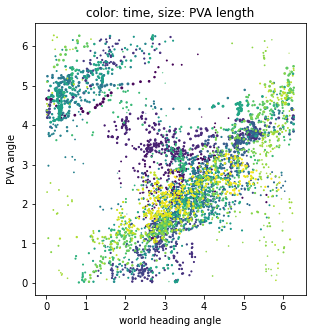

In [83]:
# TODO: make version where points are scaled by mean walking speed
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(uvrDat.posDf.angle.values[volFramePos]*np.pi/180,pvaRad,s=pvaLen*100,c=uvrDat.posDf.time.values[volFramePos])
ax.set_xlabel('world heading angle')
ax.set_ylabel('PVA angle')
ax.set_title('color: time, size: PVA length')
ax.set_aspect('equal')
fig.savefig(saveDir+sep+'headingAndPVA_corr.pdf')

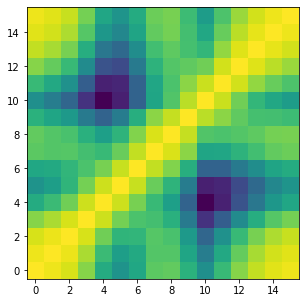

In [84]:
import scipy.stats as sts

roidat = imgDat[['{}{}'.format(roiname,i+1) for i in range(16)]].values

cc = np.zeros((16, 16))
for i in np.arange(16):
    for j in np.arange(16):
        cc[i,j] = sts.pearsonr(roidat[:,i], roidat[:,j])[0]
        
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(cc, origin='lower')
fig.savefig(saveDir+sep+'roiDFFcrosscorr.pdf')

In [ ]:
nsteps = weights.shape[0]
nvol = weights.shape[1]
pva_x = np.cos(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
pva_y = np.sin(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights

In [ ]:
# correlation window:
sgorder = 3
sgwindow = 9
lags = np.arange(-40,40)

if "background" in imgDat.columns:
    nroi = len(imgDat.columns)-2
else:
    nroi = len(imgDat.columns)-1

In [ ]:
# reimplement correlation with walking speed...